# runalyze2video v0.1

### Imports

In [2227]:
import requests
#from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from moviepy.editor import *
import numpy as np
import pandas as pd
from moviepy.config import change_settings
import cv2
import shutil
import os
from dotenv import load_dotenv
import re
import sqlite3
from PIL import Image, ImageDraw, ImageFont
import calendar
import warnings
import locale

locale.setlocale(locale.LC_ALL, 'de_DE') # Setzen des Gebietsschemas auf Deutsch
warnings.filterwarnings("ignore", category=DeprecationWarning) # Ignoriere DeprecationWarning
warnings.filterwarnings("ignore", category=FutureWarning) # Ignoriere FutureWarning
warnings.filterwarnings("ignore", category=UserWarning) # Ignoriere UserWarning

Titelgrafik
- Anzahl der Aktivitäten nehmen
- verfügbare Höhe dadurch teilen
- Titel als Textgrafik mit maximal nutzbarer Breite (und Höhe) erzeugen
- Titel stapeln und verankern

Schrift mit Halo-Effekt oder Umrandung?

Video: Einzelne Videos mit ffmpeg (ordentlicher Ein- und Ausblendeffekt), dann zusammenklöppeln

### Variables

In [2228]:
runnersite = "https://runalyze.com/athlete/Schrottie"
sportid = '800522' # 800522 = Laufen
run_mode = 2 # 1 letzte Kalenderwoche, 2 letzter Kalendermonat, 3 Benutzerdefinierter Bereich, Start und Ende erforderlich!
start_date_string = '2024-03-17'
end_date_string = '2024-03-25'
end_date = None # '2024-03-21'
max_download_frequency = 23 # Maximal alle 23 Stunden neue Daten laden. Geringere Werte möglich, aber bitte mit Vorsicht 
                            # nutzen um zu hohe Last bei runalyze.com zu vermeiden!

# Falls ImageMagick nicht installiert werden kann, einfach eine portable Version
# herunterladen und hier den Pfad angeben
change_settings({"IMAGEMAGICK_BINARY": r"C:\Users\24007120\Documents\Imagemagick\convert.exe"})

# Diverse Variablen
chart_file_pic = 'tmp/chart.png' # Temporäres Datendiagramm
save_chart = True # Soll das Diagramm gespeichert werden?
csv_file = 'tmp/activities.csv' # Name der heruntergeladenen Daten
db_filename = 'runalyze_data.db' # Name der zu verwendenden SQLite-Datenbank
table_name = 'all_data' # Name der Datentabelle

# Video
duration_per_row = 2  # Dauer der Anzeige einzelner Aktivitäten im Video in sec
fade_duration = 1  # Dauer des Überganges in sec
final_duration = 7  # Dauer der Anzeige der Gesamtdaten in sec
video_intro_png = 'stuff/intro.png' # Optional: PNG das für das Intro verwendet werden soll 
                                    # (1920x1080, min 250px breiter, freier Bereich mittig auf den oberen 1725px erfordrlich)
intro_clip_text = 'Schrotties Laufstatistik' # Text für das Intro
intro_clip_duration = 5 # Anzeigedauer des Introbildes in sec
intro_clip_fontcolor = (100, 149, 237) # Textfarbe auf dem Intro (Achtung: RGB!)
video_intro_file = 'tmp/intro.png' # Dateiname für das temporäre Introbild
video_outro_png = None # # Optional: PNG das für ein Outro verwendet werden soll 
final_video_clip = None # Nicht ändern, wird später automatisch angepasst!
final_chart_pic = None # Nicht ändern, wird später automatisch angepasst!
outro_clip_duration = 5 # Dauer eines (optionalen) Outro
fps = 30 # Videoframerate

# Text im Video formatieren
font = cv2.FONT_HERSHEY_TRIPLEX # Schriftart
font_scale = 3 # Textgröße
font_color = (107, 82, 68)  # Textfarbe für einzelne Aktivitäten (Achtung: BGR!)
sum_font_color = (79, 40, 163) # Textfarbe für die Zusammenfassung (Achtung: BGR!)
font_thickness = 7 # Textdicke

# r_type zu richtigen Aktivitäten mappen
activity_type_map = {
    994850.0: 'Easy Run',
    994854.0: 'Wettkampf',
    994855.0: 'Regenerationslauf',
    994851.0: 'Fahrtspiel',
    #'IT': 'Intervalltraining',
    #'TDL': 'Tempodauerlauf',
    994856.0: 'Longrun'
}
catch_all_activity = 'Hallenhalma' # Wenn der Aktivitätstyp nicht im Mapping enthalten ist, kommt dieser hier rein

### get_last_fetch()

Funktion zur Überprüfung des Zeitpunktes des letzten Datendownload - Liegt dieser weniger als Stunden zurück, als in 'max_download_frequency' festgelegt, erfolgt kein Download neuer Daten vom JSON-Endpunkt.

In [2229]:
def get_last_fetch():
    # SQLite-Verbindung herstellen
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Prüfen, ob die Tabelle bereits existiert
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='last_fetch'")
    table_exists = cursor.fetchone()

    if not table_exists:
        # Wird die Tabelle 'last_fetch' nicht gefunden, dann erstellen und Zeitstempel einwerfen
        cursor.execute("CREATE TABLE IF NOT EXISTS last_fetch (date TEXT)")
        current_time = datetime.now().isoformat()
        cursor.execute("INSERT INTO last_fetch (date) VALUES (?)", (current_time,))
        conn.commit()
        return 1000  # Rückgabewert 1000, damit der Download initiiert wird
    else:
        # Gibt es die Tabelle, dann jüngsten Wert nehmen und ermitteln, wieviele Stunden seither vergangen sind
        cursor.execute("SELECT date FROM last_fetch ORDER BY date DESC LIMIT 1")
        last_fetch = cursor.fetchone()
        last_fetch_date = datetime.fromisoformat(last_fetch[0])
        current_time = datetime.now()
        age = current_time - last_fetch_date
        age_hours = int(age.total_seconds() / 3600)
        return age_hours

    # Verbindung schließen
    cursor.close()
    conn.close()

### login_with_username_password

Initiiert den Login bei Runalyze, damit der Datendownload am JSON-Endpunkt auch Daten bringt. Diese werden nur an eingeloggte Benutzer herausgegeben.

In [2230]:
def login_with_username_password():
    
    load_dotenv()
    username = os.getenv('RUNALYZE_USERNAME')
    password = os.getenv('RUNALYZE_PASSWORD')
    
    login_url = 'https://runalyze.com/login'
    session = requests.Session()
    
    # HTML-Inhalt der Login-Seite holen
    response = session.get(login_url)
    html_content = response.text
    
    # CSRF-Token extrahieren
    csrf_token_match = re.search(r'<input[^>]*name=["\']?_csrf_token["\']?[^>]*value=["\']?([^"\'>\s]+)', html_content)

    if csrf_token_match:
        csrf_token = csrf_token_match.group(1)
    else:
        print("CSRF-Token konnte nicht gefunden werden.")
        return None
    
    # Anmelden
    payload = {
        '_username': username,
        '_password': password,
        '_remember_me' : 'off',
        '_csrf_token': csrf_token
    }
    response = session.post(login_url, data=payload)

    # Überprüfen, ob die Anmeldung erfolgreich war
    if response.status_code == 200:
        print("Anmeldung erfolgreich!")
        return session
    else:
        print(f"Anmeldung fehlgeschlagen. Statuscode: {response.status_code}")
        return None

### fetch_activity_data_csv

Holt die CSV-Datei mit den Aktivitätsdaten vom JSON-Endpunkt ab. Die Datei enthält alle bei Runalyze für den eingeloggten Benutzer hinterlegten Daten. Somit wird stets ein vollständiges Paket geholt.

In [2231]:
def fetch_activity_data_csv(session):
    csv_url = 'https://runalyze.com/_internal/data/activities/all'
    
    # Die CSV-Datei mit allen Daten abholen
    response = session.get(csv_url)
    
    # Überprüfen, ob der Abruf erfolgreich war
    if response.status_code == 200:
        with open(csv_file, 'wb') as f:
            f.write(response.content)
        print("CSV-Datei erfolgreich heruntergeladen.")
    else:
        print("Fehler beim Abrufen der CSV-Datei.")

### import_csv_to_sqlite

Schreibt die Daten aus dem CSV in eine SQLite-DAtenbank. Wenn darin noch keine entsprechende Tabelle existiert, wird diese angelegt und befüllt. Existiert sie schon, wird ein Backup daon gefertigt und anschließend alle Daten neu eingekippt. Sollte schn ein älteres Backup bestehen, wird das zuvor gelöscht und dann durch das neue ersetzt.

In [2232]:
def import_csv_to_sqlite():
    # Daten aus CSV-Datei lesen
    df = pd.read_csv(csv_file)

    # SQLite-Datenbankverbindung herstellen
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Prüfen, ob die Tabelle bereits existiert
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
    table_exists = cursor.fetchone()

    # Wenn die Tabelle existiert, sichere sie als 'bckp_table_name' und lösche sie
    if table_exists:
        backup_table_name = f'bckp_{table_name}'
        # Prüfen, ob die Backup-Tabelle existiert und ggf. löschen
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{backup_table_name}'")
        backup_table_exists = cursor.fetchone()
        if backup_table_exists:
            cursor.execute(f"DROP TABLE IF EXISTS {backup_table_name}")

        # Tabelle umbenennen und löschen
        cursor.execute(f"ALTER TABLE {table_name} RENAME TO {backup_table_name}")  # Sicherung der Tabelle
        cursor.execute(f"DROP TABLE IF EXISTS {table_name}")  # Tabelle löschen

    # Tabelle aus dem DataFrame erstellen
    df.to_sql(table_name, conn, index=False)

    # Zeitstempel setzen, um zu häufiges Herunterladen der CSV zu vermeiden
    cursor.execute("CREATE TABLE IF NOT EXISTS last_fetch (date TEXT)")
    current_time = datetime.now().isoformat()
    cursor.execute("INSERT INTO last_fetch (date) VALUES (?)", (current_time,))

    # Transaktion bestätigen und Verbindung schließen
    conn.commit()
    conn.close()

### query_data_from_db

Sammelt die relevanten Daten aus der SQLite-Datenbank und schreibt sie in ein Pandas-Dataframe. Gleichzeitig werden noch ein paar Variablen gestrickt, die im weiteren Verlauf erforderlich sein werden.

In [2233]:
def query_data_from_db():
    # Mapping für die Spalten zwischen Datenbank und DataFrame
    column_mapping = {
        'time': 'date',
        'sportid': 'a_type',
        'typeid': 'r_type',
        'distance': 'distance',
        'elapsedTime': 'duration'
    }
    
    global start_date
    global end_date
    # SQLite-Datenbankverbindung herstellen
    conn = sqlite3.connect(db_filename)
    
    # Spalten für die SQL-Abfrage aus dem Mapping extrahieren
    selected_columns = ', '.join(column_mapping.keys())

    # Parameter für die SQL-Abfrage bauen
    if run_mode == 1:
        start_date = int((datetime.now() - timedelta(days=datetime.now().weekday() + 7)).timestamp())
        end_date = int((datetime.now() - timedelta(days=datetime.now().weekday())).timestamp())
    elif run_mode == 2:
        today = datetime.now()
        first_day_of_last_month = today.replace(day=1) - timedelta(days=1)
        start_date = int(first_day_of_last_month.replace(day=1).timestamp())
        end_date = int(first_day_of_last_month.timestamp())
        print(start_date)
    elif run_mode == 3:
        start_date = int(datetime.strptime(start_date_string, '%Y-%m-%d').timestamp())
        end_date = int(datetime.strptime(end_date_string, '%Y-%m-%d').timestamp())
    else:
        print('Query failed!')
        return None  # Rückgabe None bei ungültigem run_mode
    
    # SQL-Abfrage für den Datenabruf
    query = f"""
        SELECT {selected_columns}
        FROM all_data
        WHERE sportid = {sportid} AND time >= '{start_date}' AND time <= '{end_date}'
    """

    # Daten aus der Datenbank abrufen
    df = pd.read_sql_query(query, conn)
    
    # Felder entsprechend dem Mapping umbenennen
    df.rename(columns=column_mapping, inplace=True)

    # Feld 'pace' berechnen (zum Beispiel als Minuten pro Kilometer)
    df['pace_tmp'] = df['duration'] / df['distance']
    # Extrahiere Minuten und Sekunden und formatiere sie als 'mm:ss'
    df['pace'] = df['pace_tmp'].apply(lambda x: '{:02d}:{:02d}'.format(int(x // 60), int(x % 60)))
    # Entferne temp. Spalte
    df.drop(['pace_tmp',], axis=1, inplace=True)

    # Umwandlung der Spalte "duration" von Sekunden in Zeitformat (hh:mm:ss)
    df['duration'] = df['duration'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%H:%M:%S'))
    df['date_timestamp'] = pd.to_datetime(df['date'], unit='s')
    # Neuen Namen für finalen Videoclip und finales Diagramm erzeugen
    start_date = datetime.utcfromtimestamp(start_date)
    end_date = datetime.utcfromtimestamp(end_date)
    min_date_str = start_date.strftime('%Y%m%d')
    max_date_str = end_date.strftime('%Y%m%d')
    global final_video_clip
    final_video_clip = f"movies/activity_movie_{min_date_str}_{max_date_str}.mp4"
    global final_chart_pic
    final_chart_pic = f"movies/chart_{min_date_str}_{max_date_str}.png"

    # Transaktion bestätigen und Verbindung schließen
    conn.commit()
    conn.close()
    # print(df.dtypes) # DEBUG!
    # print(df) # DEBUG!
    return df

### edit_intro_image

Funktion zum Bearbeiten des Intro-Bildes. Hier wird das (optionale) Introbild mit einem Text versehen.

In [2234]:
def edit_intro_image():
    # Laden des PNG-Bildes
    intro_image = Image.open(video_intro_png)
    intro_breite, intro_höhe = intro_image.size

    # Erstellen eines Zeichenobjekts für den Text
    text_image = Image.new('RGBA', (1700, 375), (255, 255, 255, 0))
    draw = ImageDraw.Draw(text_image)

    # Definieren der Schriftart und -größe
    font = ImageFont.truetype("arial.ttf", 130)

    # Text für den Laufzeitraum
    mode_text = f"{start_date.strftime('%d.%m.%Y')} bis {end_date.strftime('%d.%m.%Y')}"

    # Credits
    credit_text = '(made with runalyze2video)'
    # Gesamten Text zusammensetzen
    full_text = intro_clip_text + '\n' + mode_text + '\n' + credit_text

    # Text auf das Textbild zeichnen
    draw.text((0, 0), full_text, fill=intro_clip_fontcolor, font=font)

    # Textbild um 90 Grad drehen
    text_image = text_image.rotate(90, expand=True)

    # Horizontal zentrierte Position für den Text berechnen
    x_position = (intro_höhe - text_image.height) + 125

    # Text zentriert mit 25 Pixeln Abstand von oben einfügen
    intro_image.paste(text_image, (int(x_position), 0), text_image)

    # Bearbeitetes Bild speichern
    intro_image.save(video_intro_file)


### create_chart

Erzeugt ein Balkendiagramm mit den Daten der Aktivitäten des zu nutzenden Zeitraumes (je nach run_mode). DAbei stellt die Distanz die Balkenlänge dar und auf dem Balken wird die DAuer und die Pace angezeigt.

In [2235]:
def create_chart(activities):
    # Number of lines in the dataframe
    n_rows = activities.shape[0]

    # Create a figure object with square dimensions
    fig, ax = plt.subplots(figsize=(10, 10))

    # Set the labeling of the Y-axis to "from - to"
    min_date = datetime.utcfromtimestamp(activities['date'].min())
    max_date = datetime.utcfromtimestamp(activities['date'].max())
    min_date_str = min_date.strftime('%d.%m.%Y')
    max_date_str = max_date.strftime('%d.%m.%Y')
    ax.set_ylabel(f"{min_date_str} - {max_date_str}")

    # Create a horizontal bar plot for the distance
    for i, (dist, dur, pace) in enumerate(zip(activities["distance"], activities["duration"], activities["pace"])):
        
        # Set the color for the bars
        color = mcolors.to_rgba_array(plt.cm.bone(0.3 + i * 0.3 / n_rows))

        # Paint th bars
        ax.barh(i, dist, color=color, edgecolor='black')
        
        # Format the duration so that it is not preceded by "0 days"
        dur_formatted = str(dur).split()[-1]

        # Label the bars with the distance values on the right-hand edge of the bar
        ax.text(dist, i, f"{dur_formatted} / {pace}  ", ha='right', va='center', rotation=0, color='white')

    # Set the labels of the X-axis for the distance
    ax.set_xlabel("Running distance (km)")
    
    # Remove the labels from the Y-axis
    ax.set_yticks([])
    
    # Add gridlines as thin lines in the background
    ax.grid(True, linestyle=':', linewidth=0.5)

    # Set background color
    ax.set_facecolor('#fffff0')

    # Save chart as an image
    fig.savefig(chart_file_pic, bbox_inches='tight', dpi=350)  
    
    # Show the chart
    #plt.show()

### create_video

Erzeugt das finale Video. Ist eine Startgrafik angegeben, wird zunächst diese angezeigt, dann folgen alle einzelnen Aktivitäten sowie am Ende eine Zusammenfassung aller Daten.

In [2236]:
def create_video(df):

    # Calculate the height of text area and image area
    text_area_height = 840
    image_area_height = 1080

    # Create the video writer object
    out = cv2.VideoWriter(final_video_clip, cv2.VideoWriter_fourcc(*'mp4v'), fps, (1080, 1920))

    # Check if intro clip is provided and existing
    if video_intro_png and os.path.exists(video_intro_file):
        # Load and resize intro clip
        intro_clip = cv2.imread(video_intro_file)
        intro_clip_resized = cv2.resize(intro_clip, (1080, 1920))

        # Write intro clip to video
        for _ in range(int(fps * intro_clip_duration)):
            out.write(intro_clip_resized)

        # Create blank frame for transition
        transition_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
        cv2.rectangle(transition_frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Fill frame with white

        # Create alpha mask for blending
        alpha_mask = np.linspace(0, 255, int(fps * fade_duration)).astype(np.uint8)

        # Apply alpha blending for transition
        for alpha in alpha_mask:
            blended_frame = cv2.addWeighted(intro_clip_resized, 1 - alpha / 255, transition_frame, alpha / 255, 0)
            out.write(blended_frame)

    # Iterate through each row in DataFrame
    for index, row in df.iterrows():

        # clip first 7 characters if duration begins with '0 days'
        duration_str = str(row['duration'])
        # if duration_str[0] == '0':
        #     duration_str = duration_str[7:]

        date_str = row['date_timestamp'].strftime('%d.%m.%Y')

        # Get the running type from the map or use the original value if not found in the map
        activity_type = activity_type_map.get(row['r_type'], catch_all_activity)

        # Create text for the row
        text_lines = [
            f"{date_str}",
            f"{activity_type}",
            f"{row['distance']} km",
            f"{duration_str}",
            f"{row['pace']} min/km"
        ]
        text = '\n'.join(text_lines)

        # Create blank frame
        frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
        cv2.rectangle(frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Fill frame with white

        # Add text to frame
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x = (1080 - text_size[0]) // 2
        line_height = text_size[1] * 1.5  # Increase line height by 1.5 times
        text_y = (text_area_height - line_height * len(text_lines)) // 2 + text_size[1]  # Center text vertically
        for i, line in enumerate(text_lines):
            line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
            line_x = (1080 - line_size[0]) // 2
            line_y = int(text_y + i * line_height)  # Use adjusted line height
            cv2.putText(frame, line, (line_x, line_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        # Resize and add image to frame
        image_clip = cv2.imread(chart_file_pic)
        image_clip_resized = cv2.resize(image_clip, (1080, image_area_height))
        frame[text_area_height:, :] = image_clip_resized

        # Write frame to video for duration_per_row seconds
        for _ in range(int(fps * duration_per_row)):
            out.write(frame)

        # Create transition frame
        transition_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)

        # Add text to transition frame
        for i, line in enumerate(text_lines):
            line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
            line_x = (1080 - line_size[0]) // 2
            line_y = int(text_y + i * line_height)  # Use adjusted line height
            cv2.putText(transition_frame, line, (line_x, line_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        # Resize and add image to transition frame
        transition_frame[text_area_height:, :] = image_clip_resized
        cv2.rectangle(transition_frame, (0, 0), (1080, 840), (255, 255, 255), -1)  # Fill frame with white

        # Create alpha mask for blending
        alpha_mask = np.linspace(0, 255, int(fps * fade_duration)).astype(np.uint8)

        # Apply alpha blending for transition
        for alpha in alpha_mask:
            blended_frame = cv2.addWeighted(frame, 1 - alpha / 255, transition_frame, alpha / 255, 0)
            out.write(blended_frame)

    # Gesamtwerte ermitteln
    # Distanz
    distance_sum = round(df['distance'].sum(), 2)
    # Dauer
    df['duration'] = pd.to_timedelta(df['duration'])
    df['duration_seconds'] = df['duration'].dt.total_seconds()
    duration_sum_seconds = df['duration_seconds'].sum()
    total_duration = timedelta(seconds=duration_sum_seconds)
    duration_sum = str(total_duration)
    # Pace (hier Durchschnitt anstelle von Summe)
    pace_mean = df['pace'].apply(lambda x: datetime.strptime(x, '%M:%S')).mean().strftime('%M:%S')

    summary_text_lines = [
        "Total:",
        f"{distance_sum} km",
        f"{duration_sum}",
        f"{pace_mean} min/km" 
    ]
    summary_text = '\n'.join(summary_text_lines)
    summary_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
    cv2.rectangle(summary_frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Fill frame with white

    for i, line in enumerate(summary_text_lines):
        line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
        line_x = (1080 - line_size[0]) // 2
        line_y = int(text_y + i * line_height)  # Use adjusted line height
        cv2.putText(summary_frame, line, (line_x, line_y), font, font_scale, sum_font_color, font_thickness, cv2.LINE_AA)
        
    summary_frame[text_area_height:, :] = image_clip_resized  # Use last image clip

    for _ in range(int(fps * final_duration)):
        out.write(summary_frame)

    # Release video writer object
    out.release()
    # Clean up
    if save_chart:
        shutil.move(chart_file_pic, final_chart_pic)
    else:
        os.remove(chart_file_pic)
    os.remove(video_intro_file)

### Where all the funny things begin

Die letzte Abfrage war vor weniger als 23 Stunden oder konnte nicht ermittelt werden.


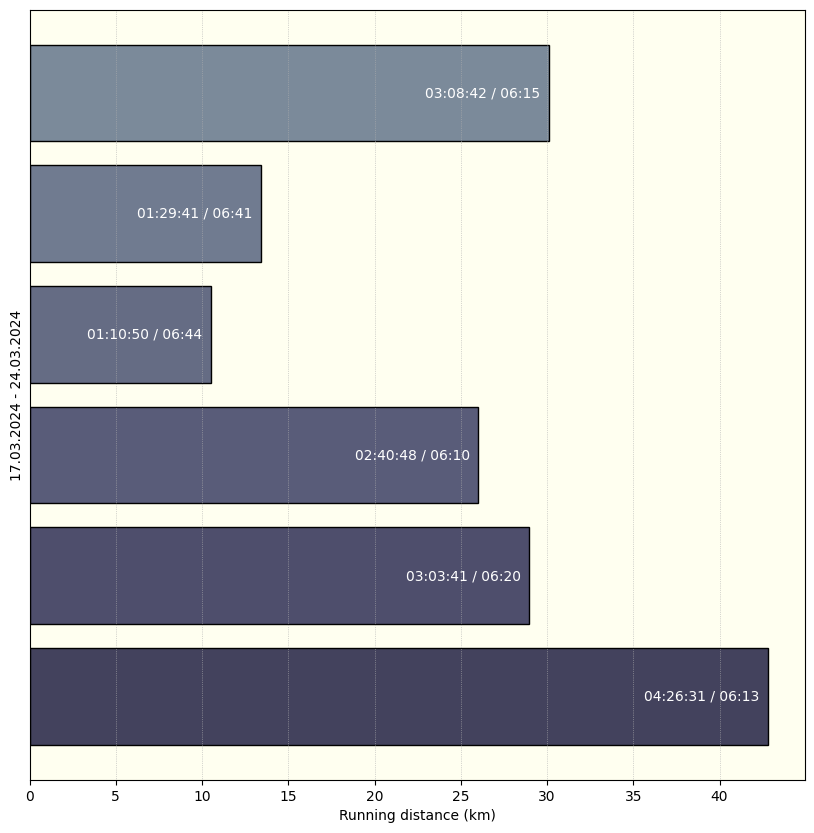

In [2237]:
# Main function
def main():
    age_in_hours = get_last_fetch()
    if age_in_hours is not None and age_in_hours > max_download_frequency:
        session = login_with_username_password()
        if session:
            # Alle Aktivitäten im CSV-Format abrufen
            fetch_activity_data_csv(session)
            # Alle neuen Aktivitäten in die Datenbank schreiben
            import_csv_to_sqlite()
    else:
        print(f"Die letzte Abfrage war vor weniger als {max_download_frequency} Stunden oder konnte nicht ermittelt werden.")

    # Prepare dataframe
    activities = query_data_from_db()
    # Edit intro pic
    edit_intro_image()
    # Create chart
    create_chart(activities)
    # # Create video
    create_video(activities)

if __name__ == "__main__":
    main()